In [1]:
"""Temporary fix for importing modules from parent directory"""
import os
import sys

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cartpole


In [2]:
from matplotlib import pyplot as plt
from tqdm import tqdm

from varitop.integrator import DelIntegrator
from varitop.opti import Varitop

import casadi as cs
import numpy as np

In [3]:
steps = 200
t0 = 0
tf = 1
tspan = [t0, tf]
ts = np.linspace(t0, tf, steps)
dt = (tspan[1] - tspan[0]) / steps

q_0 = np.array([0, 0, 0, -1])
q_f = np.array([0, 0, 0, 1])

In [4]:
di = DelIntegrator(
    nq=4,
    nu=1,
)

In [5]:
q, v, u = di.q, di.dq, di.u

In [6]:
kinetic_energy = cs.Function("kinetic", [q, v], [0.5 * v.T @ v])
potential_energy = cs.Function("potential", [q, v], [9.81 * (q[3])])
total_energy = cs.Function(
    "total", [q, v], [kinetic_energy(q, v) + potential_energy(q, v)]
)
lagrangian = cs.Function("L", [q, v], [kinetic_energy(q, v) - potential_energy(q, v)])

In [7]:
di.lagrangian = lagrangian

In [8]:
di.add_constraint(q[1])
di.add_constraint((q[2] - q[0])**2 + (q[3] - q[1])**2 - 1)

In [9]:
di.add_force(cs.vcat([u[0], 0, 0, 0]))

In [10]:
vp = Varitop(
    integrator=di,
    nsteps=steps,
    dt=dt
)

In [11]:
vp.q.shape

(4, 201)

In [12]:
vp.subject_to(vp.q[:, 0] - vp.q[:, 1] == 0)
vp.subject_to(vp.q[:, -1] - vp.q[:, -2] == 0)

In [13]:
vp.set_initial_configuration(q_0)
vp.set_terminal_configuration(q_f)

In [14]:
vp.set_initial(vp.q, np.full((steps + 1, 4), q_0).T)
vp.set_initial(vp.u, np.full((steps, 1), 10000).T)

In [15]:
cost = vp.u @ vp.u.T
vp.set_cost(cost)

In [16]:
vp.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     5397
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2190

Total number of variables............................:     1404
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1210
Total number of inequality c

OptiSol(Opti {
  instance #0
  #variables: 3 (nx = 1404)
  #parameters: 0 (np = 0)
  #constraints: 203 (ng = 1210)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})

In [17]:
qs_opt = vp.value(vp.q).T
us_opt = vp.value(vp.u).T

In [18]:
ts = np.linspace(0, tf, steps + 1)

In [19]:
qs_opt.shape

(201, 4)

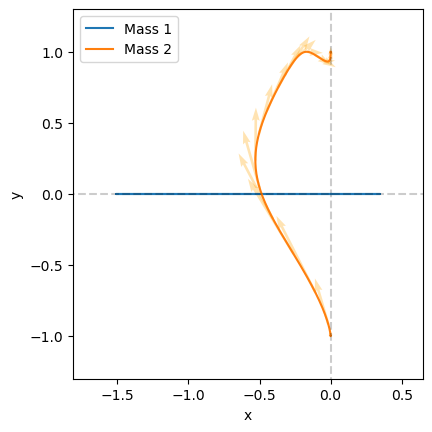

In [20]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Convert angles to Cartesian coordinates
x1 = qs_opt[:, 0]
y1 = qs_opt[:, 1]
x2 = qs_opt[:, 2]
y2 = qs_opt[:, 3]

# Calculate differences for direction
dx1 = np.diff(x1)
dy1 = np.diff(y1)
dx2 = np.diff(x2)
dy2 = np.diff(y2)


# Add a zero at the end of differences to make them the same size as x and y arrays
dx1 = np.concatenate((dx1, [0]))
dy1 = np.concatenate((dy1, [0]))
dx2 = np.concatenate((dx2, [0]))
dy2 = np.concatenate((dy2, [0]))

# Plot the trajectory with quivers
skip = 10
ax.plot(x1, y1, label='Mass 1', alpha=1)
# ax.quiver(x1, y1, dx1, dy1, angles='xy', scale_units='xy', scale=1, color='blue', alpha=0.3)
ax.plot(x2, y2, label='Mass 2')
ax.quiver(x2[::skip], y2[::skip], dx2[::skip], dy2[::skip], angles='xy', scale_units='xy', scale=0.05, color='orange', alpha=0.3)

# plot vertical line
ax.plot([0, 0], [np.min(y2) - 0.5, np.max(y2) + 0.5], 'k--', alpha=0.2)
ax.hlines(0, np.min(x1) - 0.5, np.max(x1) + 0.5, 'k', alpha=0.2, linestyles='--')
ax.set_aspect('equal')
plt.xlim(np.min(x1) - 0.3, np.max(x1) + 0.3)
plt.ylim(np.min(y2) - 0.3, np.max(y2) + 0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('trajectory.png', dpi=300)

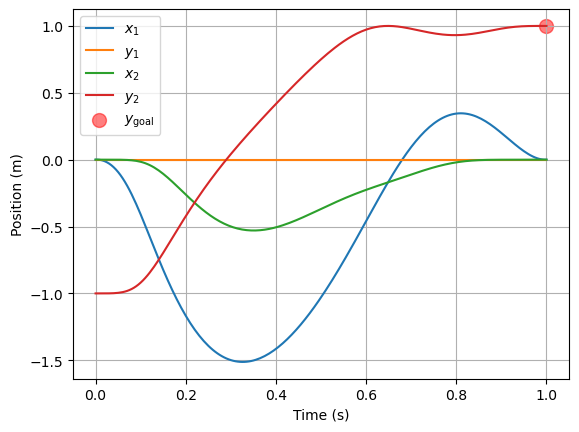

In [21]:
fig, ax = plt.subplots()

ax.plot(ts, x1, label='$x_1$')
ax.plot(ts, y1, label='$y_1$')
ax.plot(ts, x2, label='$x_2$')
ax.plot(ts, y2, label='$y_2$')

ax.scatter(1, 1, label='$y_{\\text{goal}}$', color='r', s=100, alpha=0.5)
# ax.plot([0, 0], [np.min(y2) - 0.5, np.max(y2) + 0.5], 'k--', alpha=0.2)
# ax.set_xlim([-0.1, 1.1])
ax.legend()
ax.grid()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Position (m)')
plt.savefig('positions.png', dpi=300)

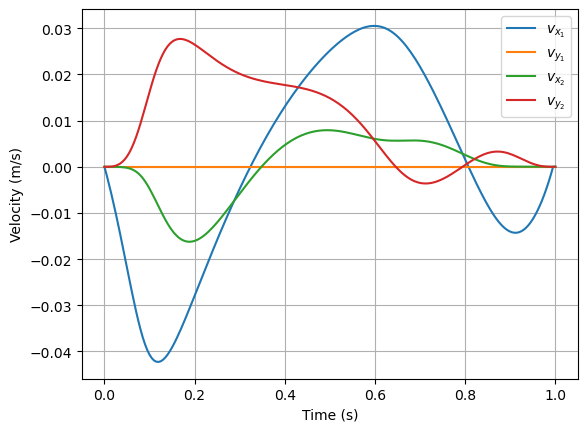

In [22]:
fig, ax = plt.subplots()

ax.plot(ts, dx1, label='$v_{x_1}$')
ax.plot(ts, dy1, label='$v_{y_1}$')
ax.plot(ts, dx2, label='$v_{x_2}$')
ax.plot(ts, dy2, label='$v_{y_2}$')

ax.legend()
ax.grid()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Velocity (m/s)')
plt.savefig('velocities.png', dpi=300)

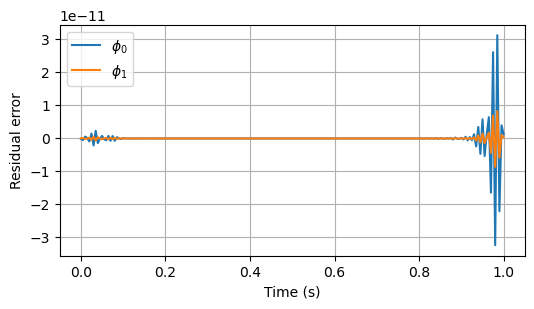

In [23]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(ts, y1, label='$\\phi_0$')
ax.plot(ts, (x2 - x1)**2 + (y2 - y1)**2 - 1, label='$\\phi_1$')

ax.grid()
# ax.set_yticks(np.linspace(0, 1, 5))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Residual error')
ax.legend()
plt.savefig('constraint_residual.png', dpi=300, bbox_inches='tight')

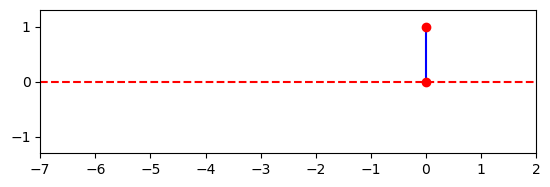

In [24]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Create a figure and axis
fig, ax = plt.subplots()

# Set the x and y limits of the plot
ax.set_xlim(-7, 2)
ax.set_ylim(-1.3, 1.3)
ax.set_aspect("equal")

# Create a line object for the line between the points
(line,) = ax.plot([], [], "b-")

# Create a scatter plot for the points
(points,) = ax.plot([], [], "ro")

# Create a horizontal line at qs_opt[1]
horizontal_line = ax.axhline(y=qs_opt[1, 1], color="r", linestyle="--")


# Animation update function
def update(frame):
    # Update the line and points data
    current = qs_opt[frame]
    line.set_data(current[[0, 2]], current[[1, 3]])
    points.set_data(current[[0, 2]], current[[1, 3]])
    # ax.set_xlim(-8, current[0] + 1.3)
    return line, points


# Create the animation
animation = FuncAnimation(fig, update, frames=len(qs_opt), blit=True)

# Show the plot
animation.save("test.gif", writer="pillow")